# Cultural Network

## Potential Datasets

- [Cultural Distance](https://world.culturalytics.com/table?countryA=&countryB=&countries=All&dimension=All&question&years=2010-2014&years=2005-2009&confidenceInterval=false&level=dimension&search=&appearance=flag-name) : many different dimensions like Altruism, political
- [Airplane Data](https://opensky-network.org/data)

## Create Network Dataset

### Cultural Similarity

In [1]:
import pandas as pd
import numpy as np
import os
import country_converter as coco
import re

In [4]:
data_folder = 'data'
data_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

data_frames = {}

for path in data_paths:
    filename = os.path.basename(path)

    
    match = re.search(r'countries-(.*?)-\d{4}', filename)
    if match:
        string_match = match.group(1).replace('-', '_')

        try:
            df_temp = pd.read_csv(path)
            data_frames[string_match] = df_temp
        except Exception as e:
            print(f"error {filename}: {e}")

In [5]:
edge_lists = []

for key in list(data_frames.keys()):
    df_temp = data_frames[key]
    
    df_edge_list = df_temp.set_index('Name')\
        .rename_axis('country_a')\
        .reset_index()\
        .melt('country_a', value_name='distance', var_name='country_b')\
        .reset_index(drop=True)
            
    df_edge_list['year_a'] = df_edge_list['country_a'].str.extract(r'(\d{4}-\d{4})')
    df_edge_list['year_b'] = df_edge_list['country_b'].str.extract(r'(\d{4}-\d{4})')
    
    df_edge_list['country_b'] = df_edge_list['country_b'].str.replace(r'\d{4}-\d{4}', '', regex=True)
    df_edge_list['country_a'] = df_edge_list['country_a'].str.replace(r'\d{4}-\d{4}', '', regex=True)
    
    df_edge_list['year_max_a'] = df_edge_list['year_a'].str.extract(r'-(\d{4})').astype(int)
    df_edge_list['year_max_b'] = df_edge_list['year_b'].str.extract(r'-(\d{4})').astype(int)
    df_edge_list['year_min_a'] = df_edge_list['year_a'].str.extract(r'(\d{4})').astype(int)
    df_edge_list['year_min_b'] = df_edge_list['year_b'].str.extract(r'(\d{4})').astype(int)
    
    df_edge_list_year_combined = pd.DataFrame()
    
    for year in df_edge_list['year_max_a'].unique():
        df_edge_list_year = df_edge_list[(df_edge_list['year_max_a'] == year)&(df_edge_list['year_max_b'] == year)]
    
        # df_edge_list = df_edge_list.sort_values(by=['year_max_a', 'year_max_b'], ascending=False).drop_duplicates(subset=['country_a', 'country_b'], keep='first')
        
        df_edge_list_year = df_edge_list_year.rename(columns={'distance':key})
        
        df_edge_list_final = df_edge_list_year[['country_a', 'country_b', key, 'year_max_a', 'year_min_a', 'year_max_b', 'year_min_b']]
        
        df_edge_list_final = df_edge_list_final[df_edge_list_final['country_a']!=df_edge_list_final['country_b']]
        
        df_edge_list_year_combined = pd.concat([df_edge_list_year_combined, df_edge_list_final], ignore_index=True)
        
    edge_lists.append(df_edge_list_year_combined)

In [6]:
edge_lists[0]

,country_a,country_b,36_dimensions,year_max_a,year_min_a,year_max_b,year_min_b
0,Algeria,Albania,0.0970,2004,1999,2004,1999
1,Argentina,Albania,0.0680,2004,1999,2004,1999
2,Bangladesh,Albania,0.1317,2004,1999,2004,1999
3,Bosnia,Albania,0.0477,2004,1999,2004,1999
4,Canada,Albania,0.1001,2004,1999,2004,1999
...,...,...,...,...,...,...,...
8401,Turkey,Zambia,0.0843,2009,2005,2009,2005
8402,Ukraine,Zambia,0.0711,2009,2005,2009,2005
8403,United States,Zambia,0.0865,2009,2005,2009,2005
8404,Uruguay,Zambia,0.1193,2009,2005,2009,2005


In [7]:
df = edge_lists[0]

for d in edge_lists[1:]:
    df = df.merge(d, how='outer', on=['country_a', 'country_b', 'year_max_a', 'year_min_a', 'year_max_b', 'year_min_b'])

    df = df[(df['country_a'] != 'Serbia and Montenegro') & (df['country_b'] != 'Serbia and Montenegro')]

# Use coco.convert with a vectorized approach for efficiency
df['ISO3_a'] = coco.convert(df['country_a'].tolist(), to='ISO3')
df['ISO3_b'] = coco.convert(df['country_b'].tolist(), to='ISO3')

In [8]:
df

,country_a,country_b,36_dimensions,year_max_a,year_min_a,year_max_b,year_min_b,neoliberalism_capitalism,norms_tradition,politics,altruism,authoritarianism,economy,egalitarianism,finance,liberitarianism,ISO3_a,ISO3_b
0,Albania,Algeria,0.0970,2004,1999,2004,1999,0.0678,0.0856,0.0689,0.0587,0.0431,0.0475,0.0749,0.0968,0.1216,ALB,DZA
1,Albania,Argentina,NaN,1998,1994,1998,1994,NaN,NaN,NaN,0.1047,0.1872,0.1738,0.1148,0.2353,0.2703,ALB,ARG
2,Albania,Argentina,0.0680,2004,1999,2004,1999,0.0709,0.0793,0.0783,0.0637,0.0915,0.0880,0.0616,0.1005,0.1362,ALB,ARG
3,Albania,Armenia,NaN,1998,1994,1998,1994,NaN,NaN,NaN,0.1130,0.1626,0.1429,0.1541,0.2141,0.2178,ALB,ARM
4,Albania,Australia,NaN,1998,1994,1998,1994,NaN,NaN,NaN,0.1850,0.2863,0.2742,0.2304,0.3533,0.4356,ALB,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11625,Zimbabwe,Uruguay,0.1752,2014,2010,2014,2010,0.1474,0.2592,0.0768,0.0825,0.0506,0.0585,0.0933,0.0510,0.3488,ZWE,URY
11626,Zimbabwe,Uzbekistan,0.1098,2014,2010,2014,2010,0.0438,0.1382,0.0828,0.1445,0.1880,0.0701,0.1158,0.1302,0.0966,ZWE,UZB
11627,Zimbabwe,Venezuela,0.0816,2004,1999,2004,1999,0.1589,0.0859,0.0597,0.0820,0.0489,0.0570,0.0386,0.0620,0.1068,ZWE,VEN
11628,Zimbabwe,Viet Nam,0.2000,2004,1999,2004,1999,0.0892,0.1358,0.2087,0.1394,0.3175,0.0912,0.0412,0.1257,0.1153,ZWE,VNM


In [ ]:
years = [y for y in range(2000, 2023)]

# Create a DataFrame with all year-country_pair combinations
year_pairs_df = pd.DataFrame([
    (year, country_a, country_b) 
    for year in years 
    for country_a in df['ISO3_a'].unique() 
    for country_b in df['ISO3_b'].unique() 
    if country_a != country_b
], columns=['target_year', 'ISO3_a', 'ISO3_b'])

print(f"Processing {len(year_pairs_df)} year-pair combinations...")

# Merge with original data
merged_df = year_pairs_df.merge(df, on=['ISO3_a', 'ISO3_b'], how='left')

# Filter for valid data points (where we have cultural data)
valid_data = merged_df.dropna(subset=df.columns.difference(['ISO3_a', 'ISO3_b', 'target_year']))

# Calculate conditions vectorized
valid_data['exact_match'] = (
    (valid_data['year_max_a'] <= valid_data['target_year']) & 
    (valid_data['year_max_b'] <= valid_data['target_year'])
)

# For exact matches, take first occurrence per group
exact_matches = (valid_data[valid_data['exact_match']]
                .groupby(['target_year', 'ISO3_a', 'ISO3_b'])
                .first()
                .reset_index())

# For non-exact matches, calculate distance and find closest
non_exact = valid_data[~valid_data['exact_match']].copy()
non_exact['distance'] = np.minimum(
    abs(non_exact['year_max_a'] - non_exact['target_year']),
    abs(non_exact['year_max_b'] - non_exact['target_year'])
)

# Find closest match for each group
closest_matches = (non_exact.loc[non_exact.groupby(['target_year', 'ISO3_a', 'ISO3_b'])['distance'].idxmin()]
                  .drop(columns=['distance'])
                  .reset_index(drop=True))

# Combine exact and closest matches
df_final = pd.concat([exact_matches, closest_matches], ignore_index=True)
df_final = df_final.rename(columns={'target_year': 'year'})

print(f"Generated {len(df_final)} records")

Processing 218638 year-pair combinations...
Generated 154390 records


C:\Users\leand\AppData\Local\Temp\ipykernel_6012\694792319.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['exact_match'] = (


In [10]:
df_year_all = df_final.drop(columns=['year_min_a', 'year_max_a', 'year_min_b', 'year_max_b', 'country_a', 'country_b'])
df_year_all.to_parquet('culture_edges.parquet', index=False)

### Language

In [11]:
df_lang = pd.read_csv('data/dicl_database.csv')

In [12]:
df_lang

,iso3_i,country_i,iso3_j,country_j,col,cor,cnl,cal,csl,lpn,lpa,lps
0,ABW,Aruba,ABW,Aruba,1.0,1.0,0.522657,0.817032,1.663123,0.013468,0.101076,0.202284
1,ABW,Aruba,AFG,Afghanistan,0.0,0.0,0.000000,NaN,NaN,0.039059,NaN,NaN
2,ABW,Aruba,AGO,Angola,0.0,0.0,0.000000,0.000000,0.000000,0.076474,0.182460,0.663155
3,ABW,Aruba,AIA,Anguilla,1.0,1.0,0.006212,0.369427,0.480583,0.189146,0.112696,0.370788
4,ABW,Aruba,ALA,Aland Islands,0.0,0.0,0.000000,NaN,NaN,0.072175,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
58559,ZWE,Zimbabwe,WSM,Samoa,1.0,1.0,0.001995,0.221007,0.275728,0.000030,0.000000,0.000189
58560,ZWE,Zimbabwe,YEM,Yemen,0.0,0.0,0.000000,0.036963,0.038707,0.000083,0.000000,0.001590
58561,ZWE,Zimbabwe,ZAF,South Africa,1.0,1.0,0.002975,0.095840,0.147180,0.638511,0.220414,2.009154
58562,ZWE,Zimbabwe,ZMB,Zambia,1.0,1.0,0.009666,0.070384,0.085157,0.747874,0.000000,0.868316


In [13]:
from sklearn.impute import KNNImputer

# Select columns to impute
impute_cols = ['csl', 'lps']

# KNNImputer works only on numeric columns, so select all numeric columns
numeric_cols = df_lang.select_dtypes(include='number').columns.tolist()

# Fit imputer on all numeric columns, but only update csl and lps
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df_lang[numeric_cols])

# Assign imputed values for csl and lps back to df_lang
df_lang['csl'] = imputed[:, numeric_cols.index('csl')]
df_lang['lps'] = imputed[:, numeric_cols.index('lps')]

years = list(range(2000, 2023))
lens = [len(years)] * len(df_lang)
df_lang_years = df_lang.loc[df_lang.index.repeat(lens)].copy()
df_lang_years['year'] = np.tile(years, len(df_lang))

In [14]:
df_lang_years

,iso3_i,country_i,iso3_j,country_j,col,cor,cnl,cal,csl,lpn,lpa,lps,year
0,ABW,Aruba,ABW,Aruba,1.0,1.0,0.522657,0.817032,1.663123,0.013468,0.101076,0.202284,2000
0,ABW,Aruba,ABW,Aruba,1.0,1.0,0.522657,0.817032,1.663123,0.013468,0.101076,0.202284,2001
0,ABW,Aruba,ABW,Aruba,1.0,1.0,0.522657,0.817032,1.663123,0.013468,0.101076,0.202284,2002
0,ABW,Aruba,ABW,Aruba,1.0,1.0,0.522657,0.817032,1.663123,0.013468,0.101076,0.202284,2003
0,ABW,Aruba,ABW,Aruba,1.0,1.0,0.522657,0.817032,1.663123,0.013468,0.101076,0.202284,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58563,ZWE,Zimbabwe,ZWE,Zimbabwe,1.0,1.0,0.387388,0.220262,0.807495,0.457951,0.000000,0.552104,2018
58563,ZWE,Zimbabwe,ZWE,Zimbabwe,1.0,1.0,0.387388,0.220262,0.807495,0.457951,0.000000,0.552104,2019
58563,ZWE,Zimbabwe,ZWE,Zimbabwe,1.0,1.0,0.387388,0.220262,0.807495,0.457951,0.000000,0.552104,2020
58563,ZWE,Zimbabwe,ZWE,Zimbabwe,1.0,1.0,0.387388,0.220262,0.807495,0.457951,0.000000,0.552104,2021


In [16]:
# df_lang_years['country_a'] = df_lang_years['iso3_i']
# df_lang_years['country_b'] = df_lang_years['iso3_j']

# df_lang_years = df_lang_years[['country_a', 'country_b', 'year', 'csl', 'lps']]

df_lang_years = df_lang_years[df_lang_years['country_i'] != df_lang_years['country_j']]  # Filter out self-loops
df_lang_years.to_parquet('language_religion_edges.parquet', index=False)

## Node Features

- Hofstede Culture Dataset

- Religion
- Ethnology

### Hofstede

In [17]:
df_hofstede = pd.read_csv('data/6-dimensions-for-website-2015-08-16.csv', sep=';')
df_hofstede['ISO3'] = coco.convert(df_hofstede['country'].tolist(), to='ISO3')
df_hofstede = df_hofstede.drop_duplicates(subset=['ISO3'], keep='first')
df_hofstede = df_hofstede[df_hofstede['ISO3'].notna()]
years = list(range(2000, pd.Timestamp.now().year + 1))
countries = df_hofstede[df_hofstede['ISO3'] != 'not found']['ISO3'].unique()

hofstede_years = pd.DataFrame([(country, year) for country in countries for year in years], columns=['ISO3', 'year'])
df_hofstede_years = hofstede_years.merge(df_hofstede, on='ISO3', how='left')
df_hofstede_final = df_hofstede_years[['ISO3', 'year', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']]

# Convert columns to numeric, coercing errors to NaN
for col in ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']:
    df_hofstede_final[col] = pd.to_numeric(df_hofstede_final[col], errors='coerce')

_hof_cols = ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']
df_before_impute_hofstede = df_hofstede_final.copy()
_total_cells_before = len(df_before_impute_hofstede) * len(_hof_cols)
_missing_before = int(df_before_impute_hofstede[_hof_cols].isna().sum().sum())
print("\n[Hofstede] Missing BEFORE:", _missing_before, f"({(_missing_before/_total_cells_before*100 if _total_cells_before else 0):.2f}%)")

imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df_hofstede_final[['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']])

df_hofstede_final[['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']] = imputed

df_after_impute_hofstede = df_hofstede_final.copy()
_total_cells_after = len(df_after_impute_hofstede) * len(_hof_cols)
_missing_after = int(df_after_impute_hofstede[_hof_cols].isna().sum().sum())
print("[Hofstede] Missing AFTER (impute-only):", _missing_after, f"({(_missing_after/_total_cells_after*100 if _total_cells_after else 0):.2f}%)")

df_hofstede_final.to_parquet('culture_nodes.parquet', index=False)

Africa East not found in regex
Africa West not found in regex
Arab countries not found in regex
Germany East not found in regex
C:\Users\leand\AppData\Local\Temp\ipykernel_6012\224035949.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hofstede_final[col] = pd.to_numeric(df_hofstede_final[col], errors='coerce')



[Hofstede] Missing BEFORE: 3770 (23.93%)
[Hofstede] Missing AFTER (impute-only): 0 (0.00%)


C:\Users\leand\AppData\Local\Temp\ipykernel_6012\224035949.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hofstede_final[['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']] = imputed


In [18]:
df_hofstede_final

,ISO3,year,pdi,idv,mas,uai,ltowvs,ivr
0,ALB,2000,68.0,25.0,57.0,29.0,61.0,15.0
1,ALB,2001,68.0,25.0,57.0,29.0,61.0,15.0
2,ALB,2002,68.0,25.0,57.0,29.0,61.0,15.0
3,ALB,2003,68.0,25.0,57.0,29.0,61.0,15.0
4,ALB,2004,68.0,25.0,57.0,29.0,61.0,15.0
...,...,...,...,...,...,...,...,...
2621,ZWE,2021,70.0,46.0,53.0,68.0,15.0,28.0
2622,ZWE,2022,70.0,46.0,53.0,68.0,15.0,28.0
2623,ZWE,2023,70.0,46.0,53.0,68.0,15.0,28.0
2624,ZWE,2024,70.0,46.0,53.0,68.0,15.0,28.0


Africa East not found in regex
Africa West not found in regex
Arab countries not found in regex
Germany East not found in regex



[Hofstede] Missing BEFORE (total): 3770 (23.69%)

Per-dimension BEFORE:
        missing_before  pct_before
pdi                832       31.37
idv                832       31.37
mas                832       31.37
uai                832       31.37
ltowvs             234        8.82
ivr                208        7.84


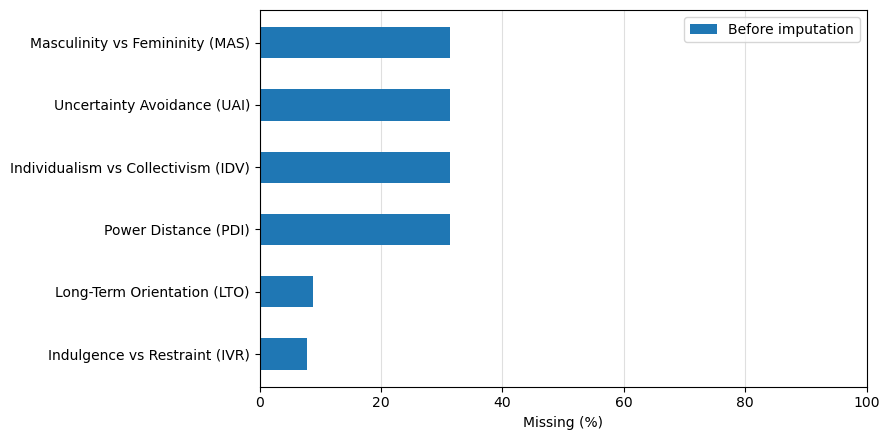

In [19]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import country_converter as coco
import warnings

warnings.filterwarnings("ignore", message=".*not found in regex.*")

cc = coco.CountryConverter()
try:
    un_iso3 = set(cc.data.loc[cc.data['UNmember'] == True, 'ISO3'])
except Exception:
    un_iso3 = set()

# Load Hofstede raw
df_hofstede = pd.read_csv('data/6-dimensions-for-website-2015-08-16.csv', sep=';')
df_hofstede['ISO3'] = coco.convert(df_hofstede['country'].tolist(), to='ISO3')

df_hofstede = df_hofstede.drop_duplicates(subset=['ISO3'], keep='first')

# Filter Iso
df_hofstede = df_hofstede[df_hofstede['ISO3'].notna()]
if len(un_iso3) > 0:
    df_hofstede = df_hofstede[df_hofstede['ISO3'].isin(un_iso3)]

years = list(range(2000, pd.Timestamp.now().year + 1))
countries = df_hofstede['ISO3'].unique()

hofstede_years = pd.DataFrame([(c, y) for c in countries for y in years], columns=['ISO3', 'year'])
df_hofstede_years = hofstede_years.merge(df_hofstede, on='ISO3', how='left')

# Select & coerce numeric
_hof_cols = ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']
df_hofstede_final = df_hofstede_years[['ISO3', 'year'] + _hof_cols].copy()
for col in _hof_cols:
    df_hofstede_final[col] = pd.to_numeric(df_hofstede_final[col], errors='coerce')

df_before_impute_hofstede = df_hofstede_final.copy()
_total_cells_before = len(df_before_impute_hofstede) * len(_hof_cols)
miss_before = df_before_impute_hofstede[_hof_cols].isna().sum()
pct_before = (miss_before / len(df_before_impute_hofstede) * 100).round(2)

print("\n[Hofstede] Missing BEFORE (total):",
      int(miss_before.sum()),
      f"({(miss_before.sum()/_total_cells_before*100 if _total_cells_before else 0):.2f}%)")
print("\nPer-dimension BEFORE:")
print(pd.DataFrame({'missing_before': miss_before, 'pct_before': pct_before}))

imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df_hofstede_final[_hof_cols])
df_hofstede_final[_hof_cols] = imputed

df_hofstede_final.to_parquet('culture_nodes.parquet', index=False)

# Mapping for descriptive labels
dim_labels = {
    'pdi': "Power Distance (PDI)",
    'idv': "Individualism vs Collectivism (IDV)",
    'mas': "Masculinity vs Femininity (MAS)",
    'uai': "Uncertainty Avoidance (UAI)",
    'ltowvs': "Long-Term Orientation (LTO)",
    'ivr': "Indulgence vs Restraint (IVR)"
}

order = pct_before.sort_values(ascending=True).index
b = pct_before.loc[order].values
labels = [dim_labels[c] for c in order]

y = np.arange(len(labels))
h = 0.5

plt.figure(figsize=(9, 4.5))
ax = plt.gca()
ax.barh(y, b, height=h, label="Before imputation") 

ax.set_xlabel("Missing (%)")
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlim(0, 100)
ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="-", alpha=0.4)
ax.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.show()


### Religion

In [18]:
religions_list = ['Christians', 'Muslims', 'Religiously_unaffiliated', 'Buddhists', 'Hindus', 'Jews', 'Other_religions']

df_religion = pd.read_csv('data/Religious Composition 2010-2020 (percentages).csv')
df_religion = (df_religion[df_religion['Level']==1])
df_religion['ISO3'] = coco.convert(df_religion['Country'].tolist(), to='ISO3')
df_religion = df_religion[df_religion['ISO3'].notna()]

years_map = {year: 2010 for year in range(2000, 2016)}
years_map.update({year: 2020 for year in range(2016, 2023)})

rows = []
for iso3 in df_religion['ISO3'].unique():
    for year in years_map.keys():
        ref_year = years_map[year]
        row = df_religion[(df_religion['ISO3'] == iso3) & (df_religion['Year'] == ref_year)]
        if not row.empty:
            row_copy = row.iloc[0].copy()
            row_copy['year'] = year
            rows.append(row_copy)

df_religion_years = pd.DataFrame(rows)

df_religion_final = df_religion_years[['ISO3', 'year','Christians', 'Muslims',
       'Religiously_unaffiliated', 'Buddhists', 'Hindus', 'Jews',
       'Other_religions']]

df_religion_final.to_parquet('language_religion_nodes.parquet', index=False)

Channel Islands not found in regex
Channel Islands not found in regex


In [5]:
df_religion_final

,ISO3,year,Christians,Muslims,Religiously_unaffiliated,Buddhists,Hindus,Jews,Other_religions
14,AFG,2000,0.100224,99.749184,0.008652,0.019986,0.000355,0.000106,0.121495
14,AFG,2001,0.100224,99.749184,0.008652,0.019986,0.000355,0.000106,0.121495
14,AFG,2002,0.100224,99.749184,0.008652,0.019986,0.000355,0.000106,0.121495
14,AFG,2003,0.100224,99.749184,0.008652,0.019986,0.000355,0.000106,0.121495
14,AFG,2004,0.100224,99.749184,0.008652,0.019986,0.000355,0.000106,0.121495
...,...,...,...,...,...,...,...,...,...
415,ZWE,2018,87.200188,0.529105,10.539887,0.037206,0.038112,0.001276,1.654226
415,ZWE,2019,87.200188,0.529105,10.539887,0.037206,0.038112,0.001276,1.654226
415,ZWE,2020,87.200188,0.529105,10.539887,0.037206,0.038112,0.001276,1.654226
415,ZWE,2021,87.200188,0.529105,10.539887,0.037206,0.038112,0.001276,1.654226


### Nationalities

In [52]:
df_nationalities = pd.read_csv('data/UNdata_Export_20250709_153145548.csv', sep=',')

In [13]:
df_nationalities = df_nationalities[(df_nationalities['Sex'] == 'Both Sexes') & 
                                    (df_nationalities['Area'] == 'Total')]
df_nationalities

,Country or Area,Year,Area,Sex,National and/or ethnic group,Record Type,Reliability,Source Year,Value,Value Footnotes
0,Åland Islands,2000,Total,Both Sexes,Total,Census - de jure - complete tabulation,"Final figure, complete",2009.0,25776.0,1
1,Åland Islands,2000,Total,Both Sexes,Finnish,Census - de jure - complete tabulation,"Final figure, complete",2009.0,5109.0,1
2,Åland Islands,2000,Total,Both Sexes,Swedish,Census - de jure - complete tabulation,"Final figure, complete",2009.0,1354.0,1
3,Åland Islands,2000,Total,Both Sexes,Other,Census - de jure - complete tabulation,"Final figure, complete",2009.0,552.0,1
4,Åland Islands,2000,Total,Both Sexes,Åland,Census - de jure - complete tabulation,"Final figure, complete",2009.0,18682.0,1
...,...,...,...,...,...,...,...,...,...,...
58616,Zambia,2000,Total,Both Sexes,African,Census - de facto - complete tabulation,"Final figure, complete",2007.0,9294154.0,NaN
58617,Zambia,2000,Total,Both Sexes,American,Census - de facto - complete tabulation,"Final figure, complete",2007.0,1198.0,NaN
58618,Zambia,2000,Total,Both Sexes,Asians,Census - de facto - complete tabulation,"Final figure, complete",2007.0,11848.0,NaN
58619,Zambia,2000,Total,Both Sexes,European,Census - de facto - complete tabulation,"Final figure, complete",2007.0,6182.0,NaN


In [14]:
df_nationalities[df_nationalities['Country or Area'] == 'Switzerland']

,Country or Area,Year,Area,Sex,National and/or ethnic group,Record Type,Reliability,Source Year,Value,Value Footnotes
